# Gender Classification
________

# Transfer Learning: VGGFace16

### Riche Ngo

In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# To read images
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import vgg16
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils

### Import Data

This is downloaded from the following Kaggle [link](https://www.kaggle.com/shadabhussain/gender-and-age).

In [2]:
# loading labels for each image from csv
data = pd.read_csv('../datasets/results.csv')
# Only slice to gender
data = data.iloc[:,0:2]
data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


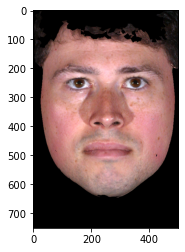

In [3]:
# Displaying an image
img=mpimg.imread('../datasets/final/Raw_0075_041_20050913115208_Portrait.png')
plt.imshow(img);

In [4]:
img.shape

(751, 501, 3)

In [5]:
# Check corresponding gender label for image
data.loc[data['Filename'] == 'Raw_0075_041_20050913115208_Portrait.png']

,Filename,Gender
40,Raw_0075_041_20050913115208_Portrait.png,0


Zero represents male.

## Preprocessing

In [9]:
# Setting image pixel size
ROWS = 64
COLS = 64
CHANNELS = 3

# Function to read images
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)   # cv2.IMREAD_GRAYSCALE
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)

In [10]:
# Test read_image function
test_image = read_image('../datasets/final/Raw_0075_041_20050913115208_Portrait.png')

In [11]:
type(test_image)

numpy.ndarray

In [12]:
test_image.shape

(64, 64, 3)

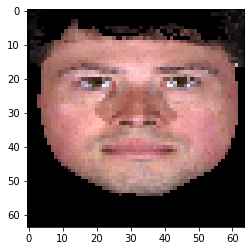

In [13]:
# View a single image again
plt.imshow(test_image);

In [14]:
# Setting the variables
X = data['Filename']
y = data['Gender']

In [15]:
# Check out the balance of genders
y.value_counts(normalize=True)

0    0.724138
1    0.275862
Name: Gender, dtype: float64

In [16]:
# Split the data into train and test subsets
# use stratify to keep the balance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
X_train.shape

(87,)

In [18]:
X_test.shape

(29,)

In [19]:
base_path = '../datasets/final/'

# Initialize numpy array
X_train_processed = np.ndarray((X_train.shape[0], ROWS, COLS, CHANNELS), dtype=np.float64)

# infill array with processed images
for i, file_name in enumerate(X_train):
    file_path = base_path + file_name
    X_train_processed[i] = read_image(file_path)
    
# Same for X_test
X_test_processed = np.ndarray((X_test.shape[0], ROWS, COLS, CHANNELS), dtype=np.float64)

for i, file_name in enumerate(X_test):
    file_path = base_path + file_name
    X_test_processed[i] = read_image(file_path)

In [20]:
X_train_processed.shape

(87, 64, 64, 3)

In [21]:
X_test_processed.shape

(29, 64, 64, 3)

In [22]:
# Scale the data
# Divide by 255 which is the full scale of each color
X_train_processed = X_train_processed/255
X_test_processed = X_test_processed/255

In [23]:
# Convert y variables to float as well
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

## CNN Model

In [26]:
# Transfer learning model
vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))

58916864/58909280 [==============================] - 7s 0us/step


In [27]:
vgg_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 128)     

In [29]:
# Add on own layers
last_layer = vgg_model.output
x = Flatten(name='flatten')(last_layer)
x = Dense(64, activation='relu', name='fc6')(x)
x = Dense(32, activation='relu', name='fc7')(x)
out = Dense(1, activation='sigmoid', name='fc8')(x)

model = Model(inputs=vgg_model.input, outputs=out)

In [30]:
len(model.layers)

23

In [80]:
# # CNN Model
# model = Sequential()

# # input layer
# model.add(Conv2D(
#     filters=32,
#     kernel_size=3,
#     activation='relu',
#     input_shape=(64,64,3)
# ))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# # model.add(Dense(128, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

# # output layer
# model.add(Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 128)      

In [32]:
# Compile model
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=10, mode='auto')

# Fit model on training data
history = model.fit(X_train_processed,
                    y_train, 
                    batch_size=1,
                    validation_data=(X_test_processed, y_test),
                    epochs=50,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
87/87 [==============================] - 9s 105ms/step - loss: 59.1016 - accuracy: 0.7126 - val_loss: 0.6590 - val_accuracy: 0.7241
Epoch 2/50
87/87 [==============================] - 9s 103ms/step - loss: 0.6333 - accuracy: 0.7241 - val_loss: 0.5887 - val_accuracy: 0.7241
Epoch 3/50
87/87 [==============================] - 9s 103ms/step - loss: 0.6247 - accuracy: 0.7241 - val_loss: 0.5911 - val_accuracy: 0.7241
Epoch 4/50
87/87 [==============================] - 9s 103ms/step - loss: 0.7922 - accuracy: 0.7241 - val_loss: 0.6348 - val_accuracy: 0.7241
Epoch 5/50
87/87 [==============================] - 9s 103ms/step - loss: 74.3845 - accuracy: 0.7241 - val_loss: 0.5624 - val_accuracy: 0.7241
Epoch 6/50
87/87 [==============================] - 9s 103ms/step - loss: 75.9732 - accuracy: 0.7241 - val_loss: 0.6175 - val_accuracy: 0.7241
Epoch 7/50
87/87 [==============================] - 9s 104ms/step - loss: 55.0261 - accuracy: 0.7241 - val_loss: 0.7085 - val_accuracy: 0.2759
Ep

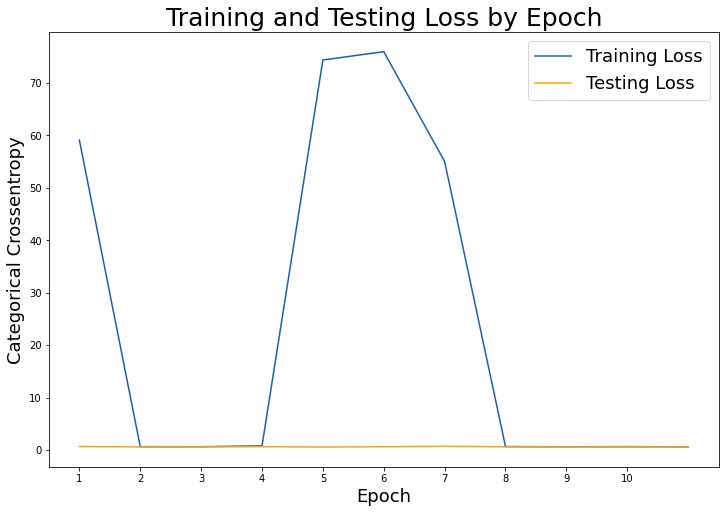

In [33]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.legend(fontsize = 18);

## Evaluation / Predictions

In [34]:
# Evaluate model on test data.
cnn_score = model.evaluate(X_test_processed, y_test, verbose=1)

cnn_labels = model.metrics_names

# Print out the scores.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')

1/1 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.7241
CNN loss  : 0.5897456407546997
CNN accuracy   : 0.7241379022598267


In [35]:
# Obtain predictions
predictions = model.predict(X_test_processed)
predictions

array([[0.293922  ],
       [0.29392433],
       [0.29394186],
       [0.29395342],
       [0.29396468],
       [0.29395744],
       [0.29395014],
       [0.2940864 ],
       [0.29405951],
       [0.2939063 ],
       [0.29394108],
       [0.29411057],
       [0.2940273 ],
       [0.29405692],
       [0.29401043],
       [0.29393888],
       [0.2939474 ],
       [0.29395682],
       [0.29395628],
       [0.29408997],
       [0.29389146],
       [0.29396263],
       [0.2938946 ],
       [0.29398873],
       [0.29394984],
       [0.29393518],
       [0.29394236],
       [0.29394168],
       [0.29392892]], dtype=float32)

70.61% Male


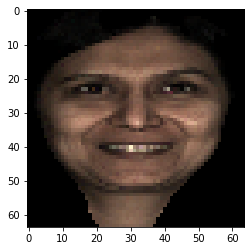

70.61% Male


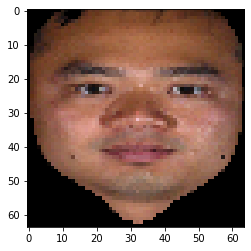

70.61% Male


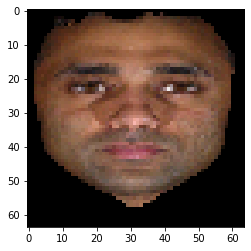

70.60% Male


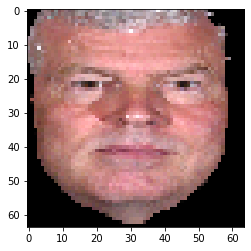

70.60% Male


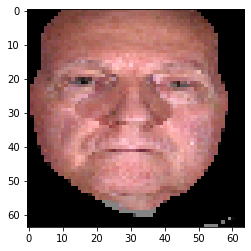

In [36]:
# Show first 5 test images and their predictions
for i in range(5):
    if predictions[i, 0] >= 0.5: 
        print('{:.2%} Female'.format(predictions[i][0]))
    else: 
        print('{:.2%} Male'.format(1-predictions[i][0]))
        
    plt.imshow(X_test_processed[i])
    plt.show();

## Predictions on new images

In [37]:
# Function to perform prediction on image
def image_gender(file_path):
    img_processed = read_image(file_path)
    img_processed = img_processed/255
    img_processed = img_processed.reshape(1, 64, 64, 3)
    prediction = model.predict(img_processed)
    
    if prediction[0][0] >= 0.5: 
        print('You are {:.2%} Female!'.format(prediction[0][0]))
    else: 
        print('You are {:.2%} Male!'.format(1-prediction[0][0]))
        
    img=mpimg.imread(file_path)   
    plt.imshow(img);

You are 70.60% Male!


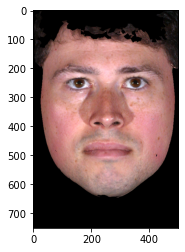

In [38]:
# Test out function
image_gender('../datasets/final/Raw_0075_041_20050913115208_Portrait.png')

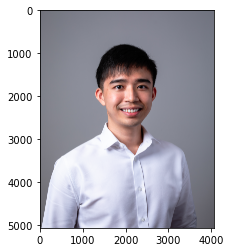

In [39]:
# Displaying actual
img=mpimg.imread('../datasets/new_images/riche_portrait.jpg')
plt.imshow(img);

In [40]:
img.shape

(5068, 4054, 3)

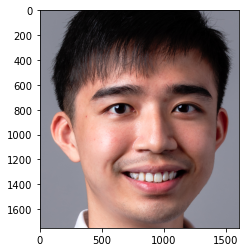

In [41]:
# crop image
# These are the height and width in train images
h = 1751
w = 1601

# Set start of slice for both axis
y = 1000
x = 1200
cropped_img = img[y:y+h, x:x+w]
plt.imshow(cropped_img);

In [42]:
# To save the cropped image
plt.imsave('../datasets/new_images/cropped_img.jpg', cropped_img)

You are 70.59% Male!


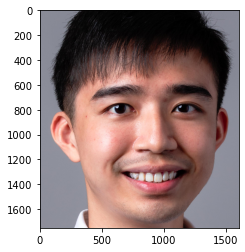

In [43]:
# Prediction on image
image_gender('../datasets/new_images/cropped_img.jpg')